<a href="https://colab.research.google.com/github/masrik-dev/skimlit-nlp-project/blob/main/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SkimLit: Research Paper Abstract Classification (PubMed 200k RCT Dataset)**

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

📖 **Resource:**
1. The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

2. And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251


In [1]:
# # Confirm access to a GPU
# !nvidia-smi -L

# **Data Preparation**

## Get the data

Since, we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 23.23 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


### Some instructions from the author regarding the `PubMed 200k RCT` dataset.

Some miscellaneous information:

* PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
* `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
* Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. To uncompress `train.7z`, you may use [7-Zip](http://www.7-zip.org/download.html) on Windows, [Keka](http://www.kekaosx.com/en/) on Mac OS X, or [p7zip](http://p7zip.sourceforge.net/) on Linux.

You are most welcome to share with us your analyses or work using this dataset!

**We would like to express our gratitude to the authors for making this valuable dataset publicly available.**

In [3]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
# Check all of the filenames in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

Here, the `train` datset is in `.zip` file. We need to unzip `train.zip` first.

In [6]:
import zipfile
import os

zip_path = data_dir + "train.zip"
extract_dir = data_dir

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [7]:
os.listdir(data_dir)

['train.zip', 'test.txt', 'train.txt', 'dev.txt']

In [8]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target file.
  """
  with open(filename, "r") as f:
    return f.readlines()  # This reads the remaining lines from the file object and returns them as a list.


In [9]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines with the training file
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

## Data Preprocessing

In [10]:
# Function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as file:
    return file.readlines()

# Read in the training lines
train_lines = get_lines(data_dir + 'train.txt')

In [11]:
def preprocess_text_with_lines(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)  # Get all lines from filename
  abstract_lines = ""  # Create an empty abstract
  abstract_samples = []  # Create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""   # Reset the abstract string if the line starts with "###"
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}  # Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t")  # Split target label from text
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()  # Get target text and lower it
        line_data["line_number"] = abstract_line_number   # What number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)  # Append line data to abstract samples lsit
    else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [12]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_lines(data_dir + "train.txt")
val_samples = preprocess_text_with_lines(data_dir + "dev.txt")
test_samples = preprocess_text_with_lines(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

2211861 28932 29493
CPU times: user 5.79 s, sys: 1.31 s, total: 7.1 s
Wall time: 10.7 s


In [13]:
# Turn the abstract lines into DataFrames
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
# Distribution of labels in the training data
train_df["target"].value_counts()

,count
target,
RESULTS,766271
METHODS,722586
CONCLUSIONS,339714
BACKGROUND,196689
OBJECTIVE,186601


In [15]:
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


Text(0.5, 1.0, 'Distribution of Total Lines in Training Data')

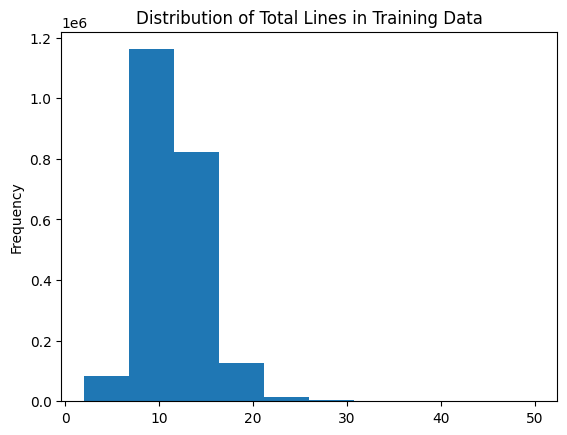

In [16]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()
plt.title("Distribution of Total Lines in Training Data")

In [17]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

In [18]:
# View the 10 lines of training sentences
train_sentences[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

### Convert Labels to Numeric Format

Convert categorical labels into numeric form (e.g., one-hot encoding) so they can be used by machine learning models.

In [19]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
print(f"Train labels:\n {train_labels_one_hot},\n\nVal_labels:\n {val_labels_one_hot},\n\nTest labels:\n {test_labels_one_hot}")


Train labels:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]],

Val_labels:
 [[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]],

Test labels:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


### Label Encode Labels

In [20]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [21]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f"Number of classes: {num_classes}\nClass names: {class_names}")

Number of classes: 5
Class names: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


# **Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings**

## Character Embeddings

### Creating a character-level tokenizer

In [22]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting no-character-level sequence into characters
import random
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}\n")
print(f"\nText splitting the above no-character-level sentence into characters:\n {split_chars(random_train_sentence)}")

Random sentence:
 docetaxel in combination with cisplatin or gemcitabine are active chemotherapy reigimes against non-small-cell lung cancer .


Text splitting the above no-character-level sentence into characters:
 d o c e t a x e l   i n   c o m b i n a t i o n   w i t h   c i s p l a t i n   o r   g e m c i t a b i n e   a r e   a c t i v e   c h e m o t h e r a p y   r e i g i m e s   a g a i n s t   n o n - s m a l l - c e l l   l u n g   c a n c e r   .


In [23]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .',
 't h i s   p a p e r   d e s c r i b e s   t h e   d e s i g n   a n d   e v a l u a t i o n   o f   p o s i t i v e   o u t l o o k   ,   a n   o n l i n e   p r o g r a m   a i m i n g   t o   e n h a n c e   t h e   s e l f - m a n a g e m e n t   s k i l l s   o f   g a y   m e n   l i v i n g   w i t h   h i v   .',
 't h i s   s t u d y   i s   d e s i g n e d   a s   a   r a n d o m i s e d   c o n t r o l l e d   t r i a l   i n   w h i c h   m e n   l i v i n g   w i t h   h i v   i n   a u s t r a l i a   w i l l   b e   a s s 

To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [24]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(147.82646377869133)

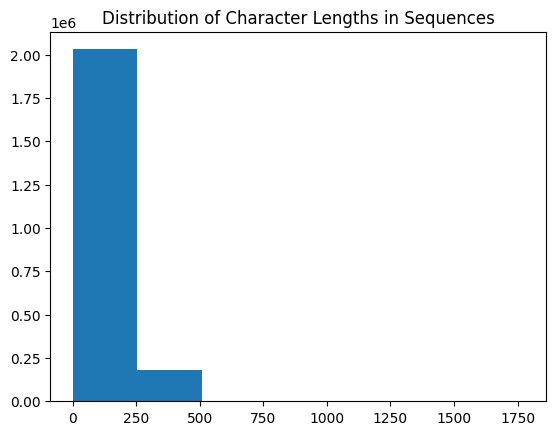

In [25]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)
plt.title("Distribution of Character Lengths in Sequences")
plt.show()

Most of our sequences are between 0 and 250 characters long, use percentile to figure out what length covers 95% of our sequences.

In [26]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

284

Now we know the sequence length which covers 95% of sequences, we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter.

In [27]:
# Get all keyboard characters for char-level embedding
import string
from tensorflow.keras.layers import TextVectorization
alphabel = string.ascii_lowercase + string.digits + string.punctuation

NUM_CHAR_TOKENS = len(alphabel) + 2   # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer",
                                    standardize="lower_and_strip_punctuation")  # None if we don't want punctuation removed


In [28]:
# Adapt character vectorizer to training character
import tensorflow as tf

# Create a streaming dataset instead of a huge in-memory list
char_ds = tf.data.Dataset.from_tensor_slices(train_chars).batch(32)

# Build the vocabulary on-the-fly, batch by batch
char_vectorizer.adapt(char_ds)

In [29]:
# Save the character vectorizer
import os
import pickle

# Make sure the folder exists
os.makedirs("model_components", exist_ok=True)

# Now save our vectorizer
with open("model_components/char_vectorizer.pkl", "wb") as file:
  pickle.dump(char_vectorizer, file)

In [30]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in char vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of characters in char vocab: 28
5 most common characters: ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('a')]
5 least common characters: [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [31]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 j a p a n e s e   p a t i e n t s   w i t h   t @ d m   w h o   c o m p l e t e d   e i t h e r   p h a s e   o f   a   @ - w e e k / @ - w e e k   s t u d y   c o m p a r i n g   l i n a g l i p t i n   m o n o t h e r a p y   w i t h   p l a c e b o   o r   v o g l i b o s e   w e r e   e l i g i b l e   t o   e n r o l   .

Length of random_train_chars: 327

Vectorized chars:
 [[27  4 14  4  6  2  9  2 14  4  3  5  2  6  3  9 20  5  3 13  3 10 15 20
  13  7 12  7 15 14 11  2  3  2 10  2  5  3 13  2  8 14 13  4  9  2  7 17
   4 20  2  2 23 20  2  2 23  9  3 16 10 19 12  7 15 14  4  8  5  6 18 11
   5  6  4 18 11  5 14  3  5  6 15  7  6  7  3 13  2  8  4 14 19 20  5  3
  13 14 11  4 12  2 22  7  7  8 21  7 18 11  5 22  7  9  2 20  2  8  2  2
  11  5 18  5 22 11  2  3  7  2  6  8  7 11  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 

### Creating character-level embedding

In [32]:
# Check if `NUM_CHAR_TOKENS` == `len(char_vocab)`
NUM_CHAR_TOKENS, len(char_vocab)

(70, 28)

In [33]:
# Create char embedding layer
from tensorflow.keras.layers import Embedding
char_embed = Embedding(input_dim=NUM_CHAR_TOKENS,  # number of different characters
                       output_dim=25,  # this is the size of the char embedding in the paper (Figure 1)
                       mask_zero=True,
                       name="char_embed")

In [34]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 j a p a n e s e   p a t i e n t s   w i t h   t @ d m   w h o   c o m p l e t e d   e i t h e r   p h a s e   o f   a   @ - w e e k / @ - w e e k   s t u d y   c o m p a r i n g   l i n a g l i p t i n   m o n o t h e r a p y   w i t h   p l a c e b o   o r   v o g l i b o s e   w e r e   e l i g i b l e   t o   e n r o l   .

Embedded chars. (after vectorization and embedding):
 [[[ 0.01503057 -0.02541355  0.03312191 ... -0.01393044  0.04231281
    0.02976494]
  [ 0.00342309  0.00134177 -0.00203427 ... -0.00478239 -0.01843243
   -0.04955957]
  [-0.00936887 -0.0427103  -0.00998124 ... -0.02830485 -0.03204372
   -0.01388432]
  ...
  [ 0.034544   -0.04942116  0.00450921 ...  0.03687424  0.00052656
   -0.0128577 ]
  [ 0.034544   -0.04942116  0.00450921 ...  0.03687424  0.00052656
   -0.0128577 ]
  [ 0.034544   -0.04942116  0.00450921 ...  0.03687424  0.00052656
   -0.0128577 ]]]

Character embedding shape: (1, 284, 25)


### Create positional embeddings

In [35]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,190654
1,190654
2,190654
3,190644
4,190357
5,189080
6,185551
7,177967
8,164187


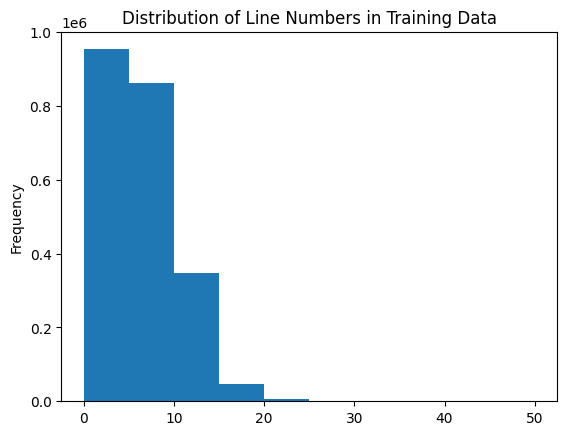

In [36]:
# Check the distribution of line numbers
train_df["line_number"].plot.hist()
plt.title("Distribution of Line Numbers in Training Data");

In [37]:
# Line numbers that are in 98 percent
np.percentile(train_df["line_number"], 98)

np.float64(15.0)

In [38]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

print(f"Train line number after one-hot-encoded:\n {train_line_numbers_one_hot[:14]}\n")
print(f"Train line number shape after one-hot-encoded:\n {train_line_numbers_one_hot.shape}")

Train line number after one-hot-encoded:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Train line number shape after one-hot-encoded:
 (2211861, 15)


Now we've encoded our line numbers feature, let's do the same for our total lines feature..

In [39]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
10,304733
11,303648
12,266682
9,259640
13,212296
8,183168
14,156015
15,111712
7,110240


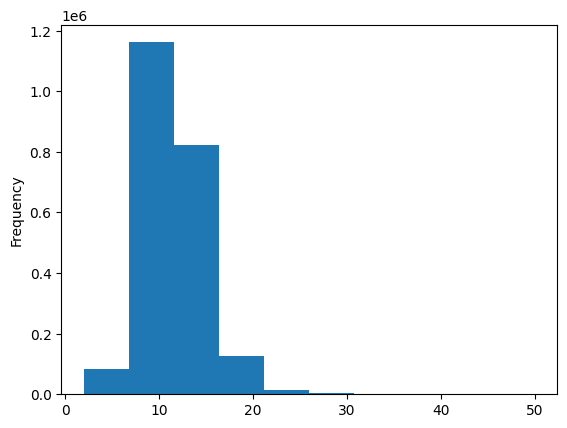

In [40]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [41]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

np.float64(20.0)

In [42]:
# Or we can use this code
val = round((np.sum(train_df.total_lines <= 20) / len(train_df.total_lines)) * 100, 2)
print(f"percentile: {val}%\ndtype: {type(val).__name__}")

percentile: 98.61%
dtype: float64


In [43]:
# Use TensorFlow to create one-hot-encoded tensors of the "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


In [44]:
# Visualize our data
print(f"Train total lines shape after one-hot-encoded:\n {train_total_lines_one_hot.shape}\n")
print(f"Train total lines after one-hot-encoded:\n {train_total_lines_one_hot[:14]}")

Train total lines shape after one-hot-encoded:
 (2211861, 20)

Train total lines after one-hot-encoded:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Pretrained token embedding USE

In [45]:
# Prepare Universal Sentence Encoder (USE)
from tensorflow.keras import Layer
import tensorflow_hub as hub
# Path to the Universal Sentence Encoder model
path = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"

# Load the USE model from TensorFlow Hub
tf_hub_embedding_layer = hub.KerasLayer(path,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Define a custom Keras Layer that uses the USE model for embedding
class Embedding(Layer):
  def call(self, x):
    return tf_hub_embedding_layer(x)


# Building a tribrid embedding model

**Steps:**
1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the ouputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a `tf.keras.Model`

In [55]:
from tensorflow.keras import layers

# Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = Embedding(name="token_embedding")(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)   # bi-LSTM for sequence data
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Setup line number inputs/model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_dense = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_dense)

# Setup total lines inputs/model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_dense)

# Combine token and char models into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

hybrid_dense = layers.Dense(256, activation="relu")(combined_embeddings)
hybrid_dropout = layers.Dropout(0.5)(hybrid_dense)

# Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 hybrid_dropout])


output_layer = layers.Dense(num_classes, activation="softmax")(tribrid_embeddings)

model = tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer,
                       name="tribrid_embedding_model")


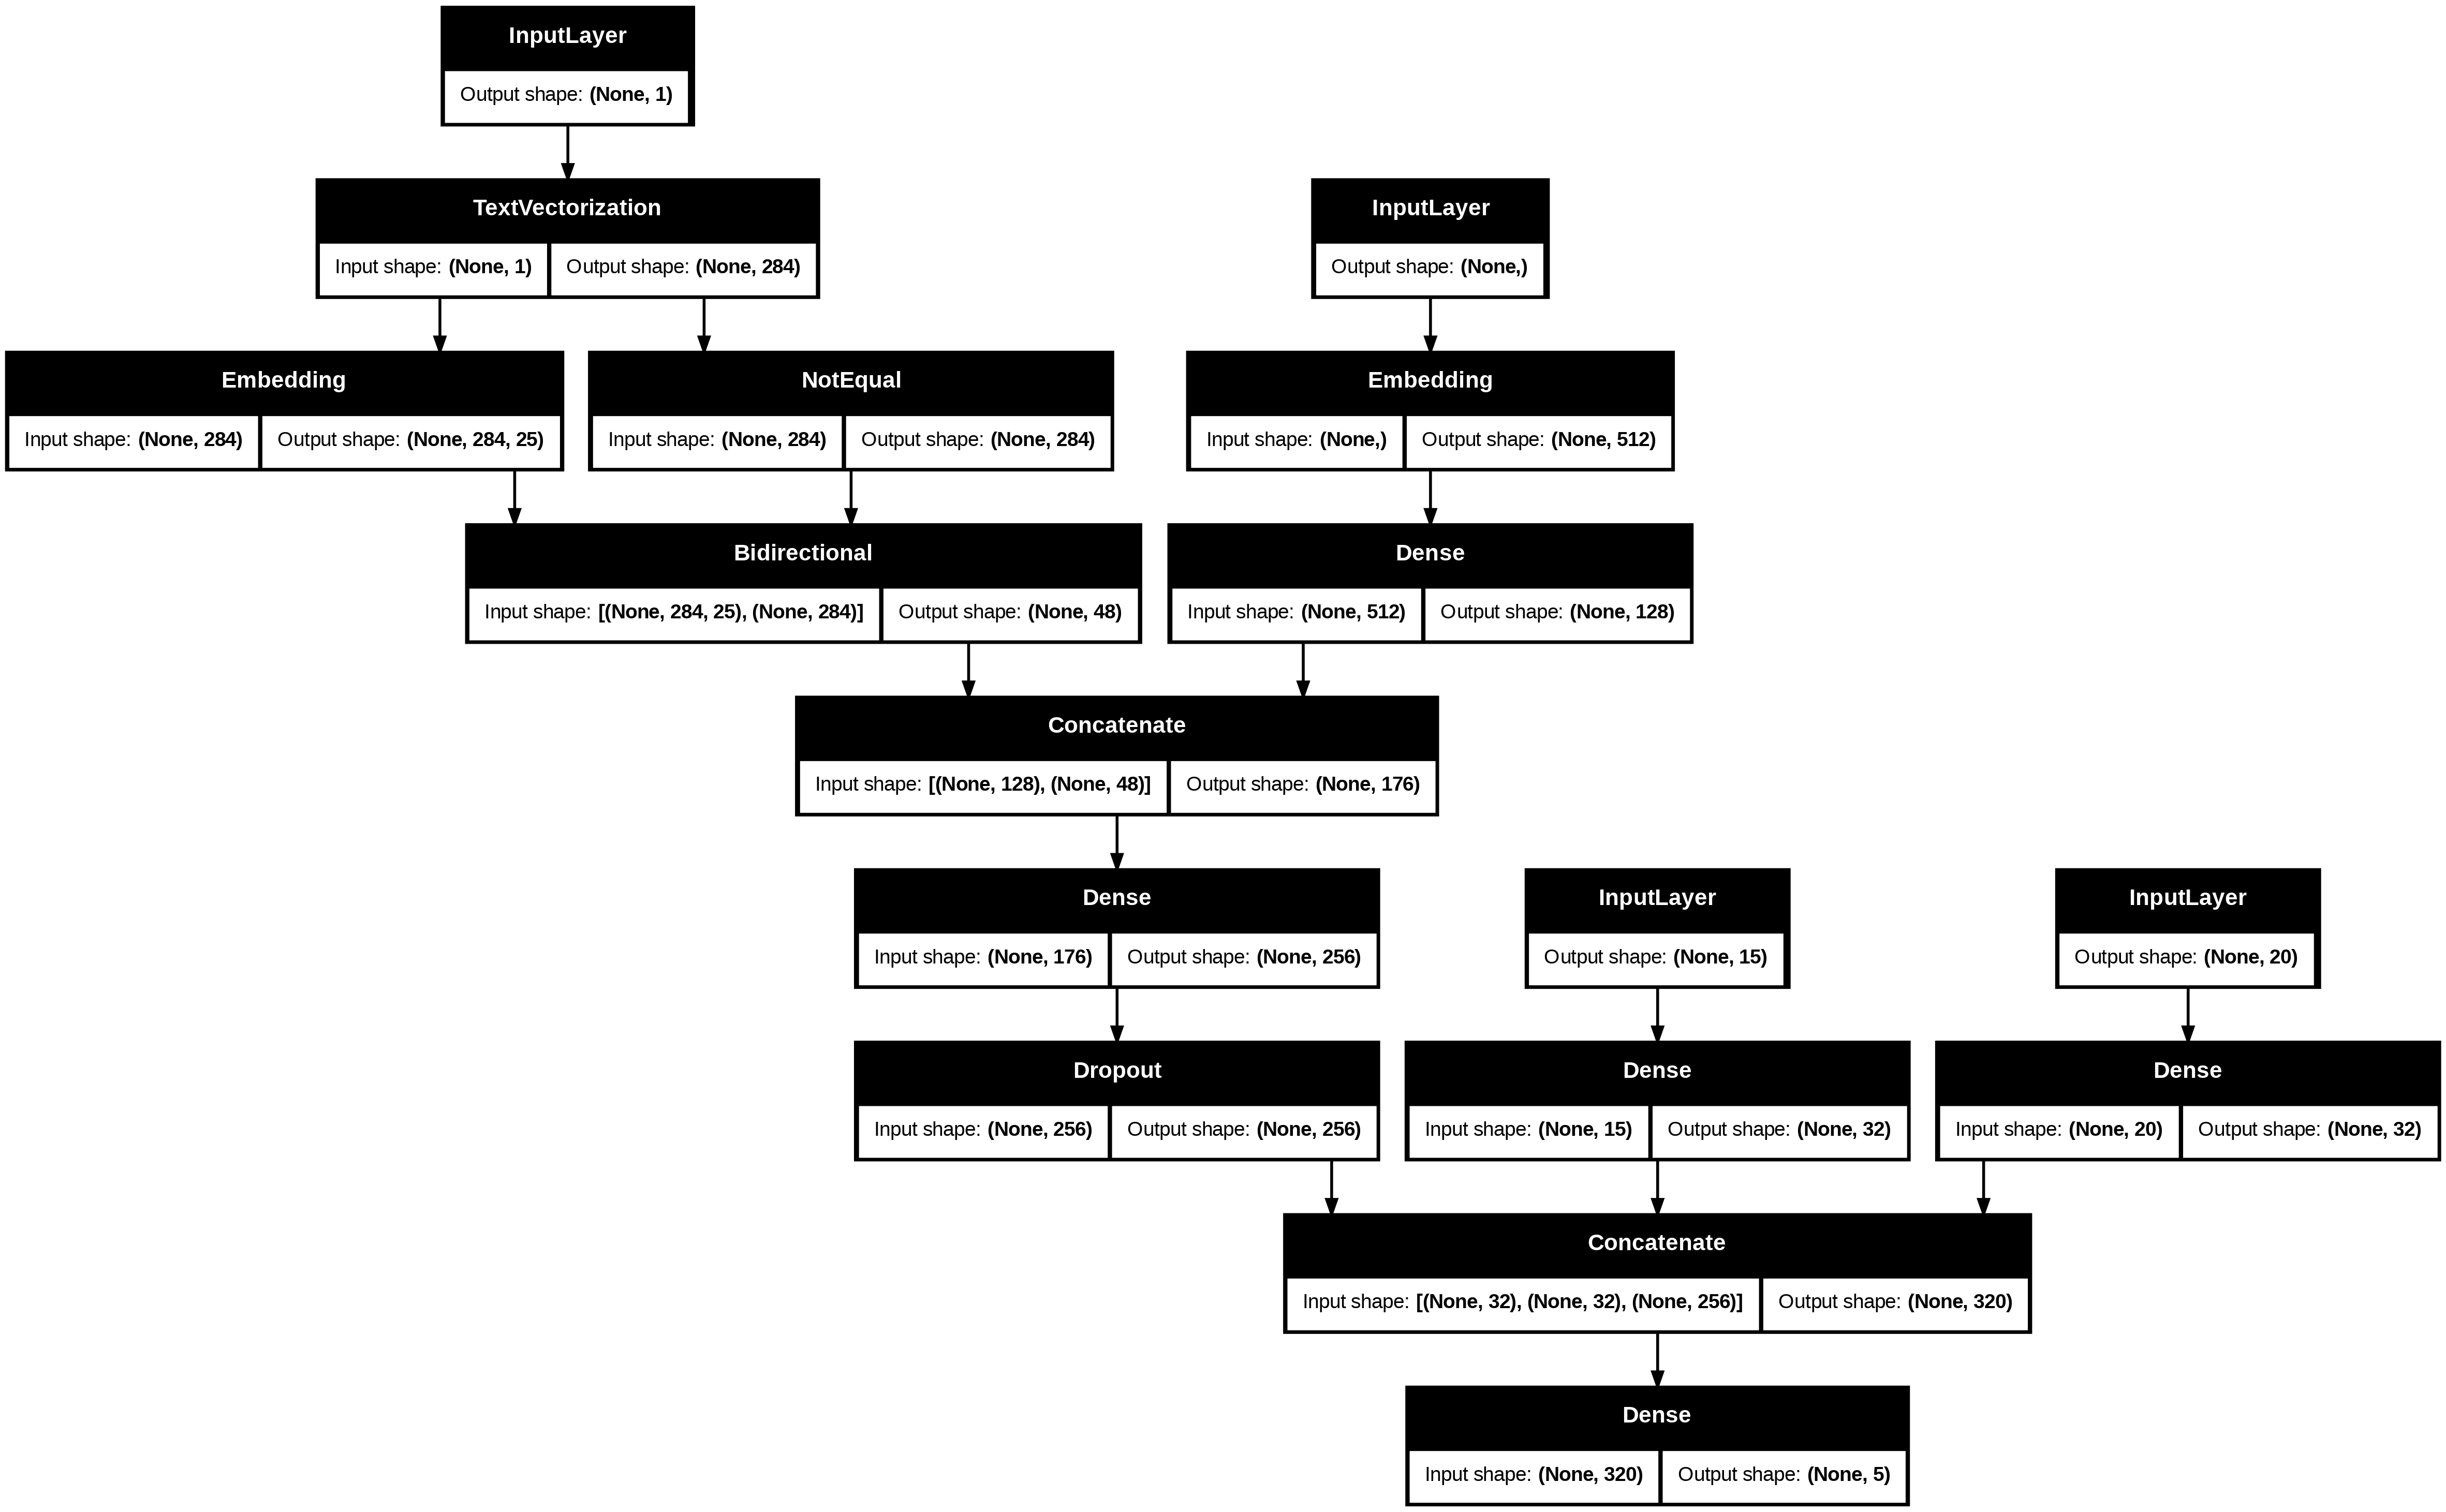

In [56]:
# Plot the tribid model
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [57]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

## Create tribrid embedding datasets and fit tribrid model

This model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

In [58]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [59]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.string, name=None), TensorSpec(shape=(None, None), dtype=tf.string, name=None)), TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None))>)

In [60]:
# Let's make the previous code's output data more structural
def print_dataset_structure(dataset, name="Dataset"):
    print(f"\n{name} structure:")
    for i, spec in enumerate(dataset.element_spec):
        if isinstance(spec, tuple):
            print(f"  Input {i+1}:")
            for j, s in enumerate(spec):
                print(f"    Feature {j+1}: shape={s.shape}, dtype={s.dtype}")
        else:
            print(f"  Output {i+1}: shape={spec.shape}, dtype={spec.dtype}")

# Example usage
print_dataset_structure(train_char_token_pos_dataset, "Train Dataset")
print_dataset_structure(val_char_token_pos_dataset, "Validation Dataset")



Train Dataset structure:
  Input 1:
    Feature 1: shape=(None, 15), dtype=<dtype: 'float32'>
    Feature 2: shape=(None, 20), dtype=<dtype: 'float32'>
    Feature 3: shape=(None,), dtype=<dtype: 'string'>
    Feature 4: shape=(None,), dtype=<dtype: 'string'>
  Output 2: shape=(None, 5), dtype=<dtype: 'float64'>

Validation Dataset structure:
  Input 1:
    Feature 1: shape=(None, None, 15), dtype=<dtype: 'float32'>
    Feature 2: shape=(None, None, 20), dtype=<dtype: 'float32'>
    Feature 3: shape=(None, None), dtype=<dtype: 'string'>
    Feature 4: shape=(None, None), dtype=<dtype: 'string'>
  Output 2: shape=(None, None, 5), dtype=<dtype: 'float64'>


## Fit the model

In [61]:
# Fit the model
history_model = model.fit(train_char_token_pos_dataset,
                          steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                          epochs=10,
                          validation_data=val_char_token_pos_dataset,
                          validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/10
1149/6912 ━━━━━━━━━━━━━━━━━━━━ 25:54 270ms/step - accuracy: 0.7075 - loss: 1.1177

KeyboardInterrupt: 

## Evaluate model on test data

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Function to calculate the metrics of a model
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Create test dataset batch and prefetch
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


## Metrics Assessment

In [ ]:
# Encode the test labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_df["target"].to_numpy())   # Fit the label encoder with training data labels
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Save the label encoder
with open("model_components/label_encoder.pkl", "wb") as file:
  pickle.dump(label_encoder, file)

# Make predictions on the test dataset
test_pred_probs = model.predict(test_pos_char_token_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)
results = calculate_results(y_true=test_labels_encoded, y_pred=test_preds)
results

In [ ]:
print(f"The model demonstrates strong overall performance with an accuracy of {results["accuracy"].2f}%")

### Make Confusion Matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_true=test_labels_encoded, y_pred=test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation="vertical")

## Find most wrong results

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

Now we'll enrich our test DataFrame with a few values:
* A `"prediction"` (string) column containing our model's prediction for a given sample.
* A `"pred_prob"` (float) column containing the model's maximum prediction probability for a given sample.
* A `"correct"` (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"]  # create binary column for whether the prediction is right or not
test_df.head()

In [ ]:
# Find top 10 most wrong samples
top_10_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:10]
top_10_wrong

### Pie chart of incorrect target distribution

In [ ]:
# Incorrect predictions distribution
import matplotlib.pyplot as plt
incorrect_predictions = test_df[test_df["correct"] == False]
incorrect_target_counts = incorrect_predictions["target"].value_counts()
plt.figure(figsize=(10, 7))
incorrect_target_counts.plot.pie(autopct="%1.1f%%", startang=90, cmap="viridis")
plt.title("Incorrect Targets Distribution")
plt.ylabel("")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average confidence for each false decision for target
false_predictions = test_df[~test_df["correct"]]
avg_confidence_per_target = false_predictions.groupby("target")["pred_prob"].mean()

# Sort the average confidence in ascending order
avg_confidence_per_target = avg_confidence_per_target.sort_values()

# Plot the average confidence for each false decision for target
ax = avg_confidence_per_target.plot(kind="bar", figsize=(10, 7), color=plt.cm.Paired(range(len(avg_confidence_per_target))), title="Average Confidence for Each False Decision by Target")
plt.xlabel("Target")
plt.ylabel("Average Confidence")

# Add percentages on top of the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()), ha="center", va="center", xytext=(0, 8), testcoords="offset points")

plt.show()

# Try model on example_abstracts

In [ ]:
# Import the example abstracts
import json
with open("example_abstracts.json", "r") as f:
  abstracts = json.load(f)

# Create sentencizer
from spacy.lang.en import English
nlp = English()
sentencizer = nlp.add_pipe("sentencizer")
doc = nlp(abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go throught each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

Now we've got `"line_number"` and `"total_lines"` values, we can one-hot encode them with `tf.one_hot` just like we did with our training dataset (using the same values for the `depth` parameter).

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

In [ ]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

In [ ]:
%%time
# Make predictions on sample abstract features
test_abstract_pred_probs = model.predict(x=(test_abstract_line_numbers_one_hot,
                                            test_abstract_total_lines_one_hot,
                                            tf.constant(abstract_lines),
                                            tf.constant(abstract_chars)))
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)

test_abstract_pred_classes = [one_hot_encoder.categories_[0][i] for i in test_abstract_preds]
print(f"Test abstract pred probs:\n {test_abstract_pred_probs}\n")
print(f"Test abstract preds:\n {test_abstract_preds}\n")
print(f"Test abstract pred classes:\n {test_abstract_pred_classes}")

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

###